In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

In [3]:
visitors=pd.read_excel('../../../Desktop/Data Science Final Project/Monthly arrivals/International Visitors to NYC.xls')

In [4]:
visitors['Year and Month'] = pd.to_datetime(visitors['Year and Month'])
visitors.set_index('Year and Month', inplace=True)
visitors.head()

,International Visitors,Year,Month,EUR/USD average monthly exchange rate
Year and Month,,,,
2007-01-01,296193,2007,1,1.299218
2007-02-01,311727,2007,2,1.307155
2007-03-01,418833,2007,3,1.323835
2007-04-01,451262,2007,4,1.349975
2007-05-01,437930,2007,5,1.351307


### Exploratory Data Analysis

In [5]:
visitors.describe()

,International Visitors,Year,Month,EUR/USD average monthly exchange rate
count,84.000000,84.000000,84.000000,84.000000
mean,514164.476190,2010.000000,6.500000,1.367088
std,103142.040168,2.012012,3.472786,0.080824
min,296193.000000,2007.000000,1.000000,1.221578
25%,446171.500000,2008.000000,3.750000,1.307376
50%,531698.000000,2010.000000,6.500000,1.350519
75%,584491.250000,2012.000000,9.250000,1.426265
max,709465.000000,2013.000000,12.000000,1.576778


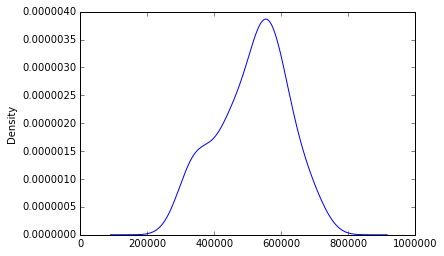

In [6]:
visitors['International Visitors'].plot(kind='density')

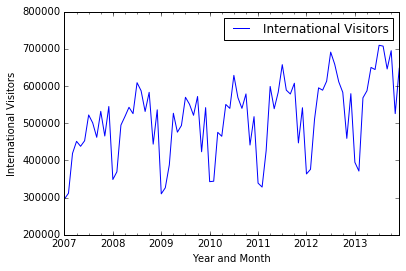

In [7]:
visitors[['International Visitors']].plot(x=visitors.index)
plt.ylabel('International Visitors')
plt.xlabel('Year and Month')

### Exploratory Data Analysis Summary:

The probability distribution above shows a slightly left leaning skew. The data looks like it is normally distributed however, so it does not seem like any data transformation is needed.

The time series chart above shows the number of international visitors arriving through New York City airports for every month from 2007 to 2013. This time series shows both a postive trend and seasonal patterns in the numbers of visitors. The numbers seem to gradually go up from January and reach their apex around July and then go down until they reach the lowest point in around November.

### What model to use?
Since this is a time series model, the most appropriate techniques to use would be either Autoregressive (AR), Moving average (MA), or the combined ARMA model. 

Let's explore the data to see what model might make the most sense to use.

In [8]:
#Using autocorrelation on a monthly basis
visitors['International Visitors'].autocorr(lag=1)

0.58288754317129399

In [9]:
#Using autocorrelation on a yearly basis
visitors['International Visitors'].autocorr(lag=12)

0.89829208354545642

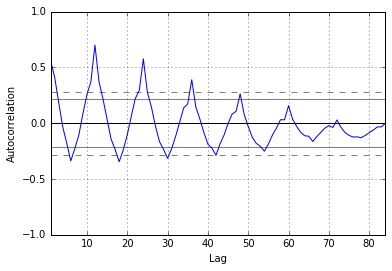

In [10]:
from pandas.tools.plotting import autocorrelation_plot
x = visitors['International Visitors']
autocorrelation_plot(x)

The plot above is another way to visualize how a lag of 12 (same month year over year) produces the highest autocorrelation.

### Autocorrelation:

According to the numbers above, there is a significant degree of autocorrelation between the number of visitors for different months and years.

Not surprisingly,the same months for different years have higher autocorrelation than just looking at a month to month relationship.

The fact that autocorrelation exists, suggests that the **AR model** might work well in this case.

The plots below offer a different ways to look at the autocorrelation of this time series.

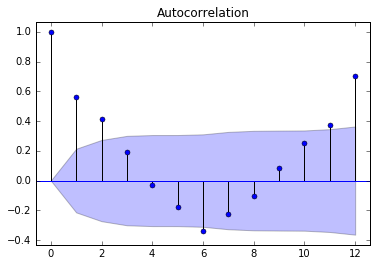

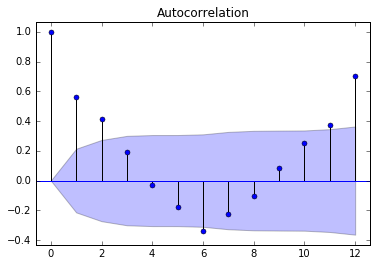

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(visitors['International Visitors'],lags=12)

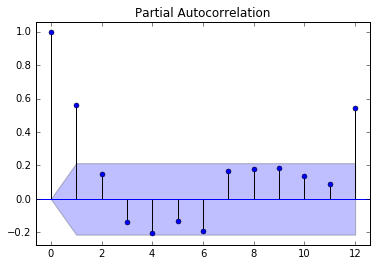

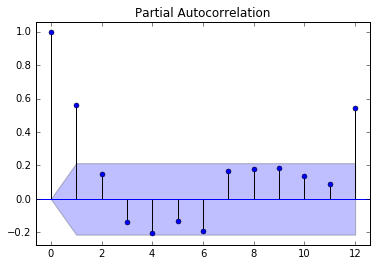

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(visitors['International Visitors'],lags=12)

### What to do about the trend?

Since there is an upward trend in this time series, we have non stationarity. In order to create a strong model we should ideally have autocorrelation (which we have) and stationarity. 

We will therefore have to do some transformation regarding the trend through either detrending or differencing.This will be done later on, because in this notebook we will first look at models that use the non stationary data in order to compare the performance with models that use the stationary data.

### What about the MA model?

MA models tend to be beneficial when the time series data has abrupt changes. Let's see from the data we have if there are such abrupt changes.

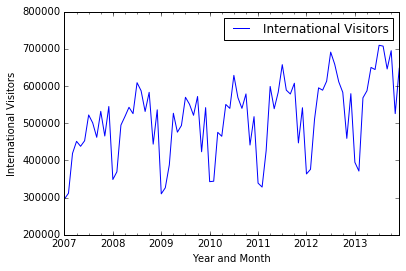

In [13]:
visitors[['International Visitors']].plot(x=visitors.index)
plt.ylabel('International Visitors')
plt.xlabel('Year and Month')


There does not seem to be abrupt changes in the number of visitors, but rather a pretty clear seasonal pattern occuring every year with a general upward trend. This graph does not suggest that using an MA model in necessary. However, this model could be used to see how it performs compared to the AR model.

In [14]:
# The code below is another way to see if there is a year over year trend in terms of the number of visitors. 
# The fact that the average annual number of visitors is increasing from 2007 to 2013 shows that there is an upward trend.
visitors['International Visitors'].groupby(by=visitors['Year']).mean()

Year
2007    449702
2008    507478
2009    474981
2010    499372
2011    519594
2012    552456
2013    595565
Name: International Visitors, dtype: int64

/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=2,center=False).mean()
  if __name__ == '__main__':


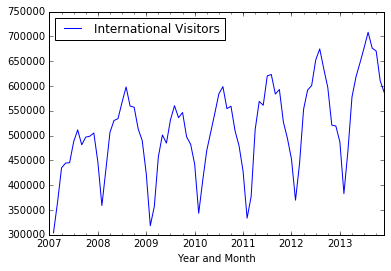

In [15]:
pd.rolling_mean(visitors[['International Visitors']], 2).plot(x=visitors.index)

The plot above uses rolling mean and shows a smoother version of the seasonal pattern.

### Setting the training and test sets

In [16]:
n = len(visitors[['International Visitors']])

train = visitors['International Visitors'][:int(.75*n)]
test = visitors['International Visitors'][int(.75*n):]

In [17]:
train=train.map(lambda x: x+0.0)
train.head()

Year and Month
2007-01-01    296193.0
2007-02-01    311727.0
2007-03-01    418833.0
2007-04-01    451262.0
2007-05-01    437930.0
Name: International Visitors, dtype: float64

In [18]:
test=test.map(lambda x: x+0.0)
test.head()

Year and Month
2012-04-01    595079.0
2012-05-01    588703.0
2012-06-01    612899.0
2012-07-01    691125.0
2012-08-01    658443.0
Name: International Visitors, dtype: float64

### Using an AR model:

In order to see what parameter would work best for the AR model I tried using different parameters in terms of the previous time points to include. The code below shows how this was done. There is a conclusion below about the finding.

In [19]:
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

#### Comparing model performance with different lags

In [20]:
for n in range(1,12):
    model = sm.tsa.ARMA(train, (n,0)).fit()
    predictions = model.predict(
    '2012-04-01',
    '2013-12-01 ',
    dynamic=True, 
)
    print("Mean absolute error: ", mean_absolute_error(test, predictions))


/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


('Mean absolute error: ', 131058.02327315162)
('Mean absolute error: ', 132249.34421454242)
('Mean absolute error: ', 129331.04454904173)
('Mean absolute error: ', 126598.33053736686)
('Mean absolute error: ', 122944.98538098045)
('Mean absolute error: ', 119016.95052941551)
('Mean absolute error: ', 119091.73013183098)
('Mean absolute error: ', 118683.80686000748)
('Mean absolute error: ', 117877.71243524396)
('Mean absolute error: ', 114965.1221819214)
('Mean absolute error: ', 110664.68448150756)


/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [21]:
for n in range(1,12):
    model = sm.tsa.ARMA(train, (n,0)).fit()
    print model.summary()

                                ARMA Model Results                                
Dep. Variable:     International Visitors   No. Observations:                   63
Model:                         ARMA(1, 0)   Log Likelihood                -800.877
Method:                           css-mle   S.D. of innovations          80124.261
Date:                    Fri, 02 Dec 2016   AIC                           1607.754
Time:                            12:20:32   BIC                           1614.184
Sample:                        01-01-2007   HQIC                          1610.283
                             - 03-01-2012                                         
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const                         4.867e+05   1.91e+04     25.508      0.000      4.49e+05  5.24e+05
ar.L1.International Visitors     0.4784      

/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                ARMA Model Results                                
Dep. Variable:     International Visitors   No. Observations:                   63
Model:                        ARMA(11, 0)   Log Likelihood                -792.071
Method:                           css-mle   S.D. of innovations          68733.861
Date:                    Fri, 02 Dec 2016   AIC                           1610.142
Time:                            12:20:44   BIC                           1638.003
Sample:                        01-01-2007   HQIC                          1621.100
                             - 03-01-2012                                         
                                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
const                          4.896e+05   1.16e+04     42.300      0.000      4.67e+05  5.12e+05
ar.L1.International Visitors      0.2354  

#### Conclusion:

Looking at the performances of the models using lags between 1 and 11, the models that perform the best when looking at the statistical significance of the different lags included and the Mean absolute error(MAE) are the ones that use a lag of 1 and 6. The AR(1) model has a MAE of 131058.02 and a p-value of 0.000. For AR(6), its MAE of 119016.95 is lower while 2 of its 6 time lags are statistically significant.

### Using an MA model:

As with the AR model, this model has been run using different lags between 1 and 11, so we can compare what lag works best.



In [22]:
for n in range(1,12):
    model = sm.tsa.ARMA(train, (0,n)).fit()
    predictions = model.predict(
    '2012-04-01',
    '2013-12-01 ',
    dynamic=True, 
)
    print("Mean absolute error: ", mean_absolute_error(test, predictions))
    

('Mean absolute error: ', 131367.48929748996)
('Mean absolute error: ', 130193.87599587829)
('Mean absolute error: ', 131190.11601230857)
('Mean absolute error: ', 131090.59463278655)
('Mean absolute error: ', 134514.60217499311)
('Mean absolute error: ', 130314.98391730919)


/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


('Mean absolute error: ', 135795.66013287558)


/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


('Mean absolute error: ', 132630.35070962954)


/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


('Mean absolute error: ', 133730.88079813891)


/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


('Mean absolute error: ', 143004.28479094995)
('Mean absolute error: ', 127045.22247084968)


/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [23]:
for n in range(1,12):
    model = sm.tsa.ARMA(train, (0,n)).fit()
    print model.summary()

                                ARMA Model Results                                
Dep. Variable:     International Visitors   No. Observations:                   63
Model:                         ARMA(0, 1)   Log Likelihood                -803.321
Method:                           css-mle   S.D. of innovations          83380.808
Date:                    Fri, 02 Dec 2016   AIC                           1612.643
Time:                            12:20:56   BIC                           1619.072
Sample:                        01-01-2007   HQIC                          1615.171
                             - 03-01-2012                                         
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const                         4.867e+05   1.41e+04     34.530      0.000      4.59e+05  5.14e+05
ma.L1.International Visitors     0.3473      

/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                ARMA Model Results                                
Dep. Variable:     International Visitors   No. Observations:                   63
Model:                         ARMA(0, 7)   Log Likelihood                -793.520
Method:                           css-mle   S.D. of innovations          68407.220
Date:                    Fri, 02 Dec 2016   AIC                           1605.039
Time:                            12:20:58   BIC                           1624.327
Sample:                        01-01-2007   HQIC                          1612.625
                             - 03-01-2012                                         
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const                         4.916e+05   4380.432    112.227      0.000      4.83e+05     5e+05
ma.L1.International Visitors     0.3828      

/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                ARMA Model Results                                
Dep. Variable:     International Visitors   No. Observations:                   63
Model:                         ARMA(0, 8)   Log Likelihood                -792.652
Method:                           css-mle   S.D. of innovations          68298.609
Date:                    Fri, 02 Dec 2016   AIC                           1605.305
Time:                            12:20:59   BIC                           1626.736
Sample:                        01-01-2007   HQIC                          1613.734
                             - 03-01-2012                                         
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const                         4.867e+05   1.11e+04     43.777      0.000      4.65e+05  5.09e+05
ma.L1.International Visitors     0.3800      

/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                ARMA Model Results                                
Dep. Variable:     International Visitors   No. Observations:                   63
Model:                         ARMA(0, 9)   Log Likelihood                -792.543
Method:                           css-mle   S.D. of innovations          68033.109
Date:                    Fri, 02 Dec 2016   AIC                           1607.086
Time:                            12:21:01   BIC                           1630.660
Sample:                        01-01-2007   HQIC                          1616.358
                             - 03-01-2012                                         
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const                         4.867e+05   1.09e+04     44.536      0.000      4.65e+05  5.08e+05
ma.L1.International Visitors     0.3679      

/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                ARMA Model Results                                
Dep. Variable:     International Visitors   No. Observations:                   63
Model:                        ARMA(0, 10)   Log Likelihood                -787.159
Method:                           css-mle   S.D. of innovations          58986.775
Date:                    Fri, 02 Dec 2016   AIC                           1598.318
Time:                            12:21:03   BIC                           1624.036
Sample:                        01-01-2007   HQIC                          1608.433
                             - 03-01-2012                                         
                                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
const                          4.867e+05        nan        nan        nan           nan       nan
ma.L1.International Visitors      0.1669  

/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                ARMA Model Results                                
Dep. Variable:     International Visitors   No. Observations:                   63
Model:                        ARMA(0, 11)   Log Likelihood                -786.249
Method:                           css-mle   S.D. of innovations          55190.509
Date:                    Fri, 02 Dec 2016   AIC                           1598.499
Time:                            12:21:08   BIC                           1626.360
Sample:                        01-01-2007   HQIC                          1609.457
                             - 03-01-2012                                         
                                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
const                          4.867e+05   7166.671     67.916      0.000      4.73e+05  5.01e+05
ma.L1.International Visitors      0.4168  

#### Conclusion:

When comparing the performance of the model run with the different lags, the model with a lag of 2 performs best overall. Its 2 included lags are statistically significant and its MAE of 130193.88  is relatively good compared to other lags.

This MA model seems to be slightly better than the best two AR models.

### Using an ARMA model:

An ARMA model was put together that combines the lags from the best AR models and the best MA model. Below are the results.

In [28]:
model = sm.tsa.ARIMA(train, (1, 0, 2)).fit()
print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 127045.22247084968)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                                
==================================================================================
Dep. Variable:     International Visitors   No. Observations:                   63
Model:                         ARMA(1, 2)   Log Likelihood                -799.507
Method:                           css-mle   S.D. of innovations          78319.689
Date:                    Fri, 02 Dec 2016   AIC                           1609.014
Time:                            12:23:42   BIC                           1619.730
Sample:                        01-01-2007   HQIC                          1613.229
                             - 03-01-2012                                         
================================================================================================
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const                         4.867e+05   2.12e+04     22.950      0.000      4.45e+05  5.28e+05
ar.L1.International Visitors     0.4678      0.256      1.825      0.073        -0.035     0.970
ma.L1.International Visitors    -0.0557      0.273     -0.204      0.839        -0.591     0.480
ma.L2.International Visitors     0.2186      0.132      1.654      0.103        -0.040     0.478
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1376           +0.0000j            2.1376            0.0000
MA.1            0.1275           -2.1348j            2.1387           -0.2405
MA.2            0.1275           +2.1348j            2.1387            0.2405
-----------------------------------------------------------------------------
"""

In [25]:
model = sm.tsa.ARIMA(train, (6, 0, 2)).fit()
print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 127045.22247084968)


/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                                
==================================================================================
Dep. Variable:     International Visitors   No. Observations:                   63
Model:                         ARMA(6, 2)   Log Likelihood                -792.782
Method:                           css-mle   S.D. of innovations          69640.897
Date:                    Fri, 02 Dec 2016   AIC                           1605.564
Time:                            12:21:10   BIC                           1626.995
Sample:                        01-01-2007   HQIC                          1613.993
                             - 03-01-2012                                         
================================================================================================
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const                         4.904e+05   8010.672     61.220      0.000      4.75e+05  5.06e+05
ar.L1.International Visitors     0.4255      0.388      1.098      0.277        -0.334     1.185
ar.L2.International Visitors     0.0117      0.331      0.035      0.972        -0.637     0.660
ar.L3.International Visitors    -0.0078      0.178     -0.044      0.965        -0.357     0.341
ar.L4.International Visitors    -0.1074      0.150     -0.718      0.476        -0.401     0.186
ar.L5.International Visitors    -0.0546      0.150     -0.364      0.717        -0.348     0.239
ar.L6.International Visitors    -0.3426      0.164     -2.090      0.041        -0.664    -0.021
ma.L1.International Visitors    -0.1835      0.413     -0.445      0.658        -0.992     0.625
ma.L2.International Visitors     0.1204      0.305      0.395      0.694        -0.477     0.718
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9274           -0.5121j            1.0594           -0.0803
AR.2            0.9274           +0.5121j            1.0594            0.0803
AR.3           -1.0764           -0.6921j            1.2797           -0.4091
AR.4           -1.0764           +0.6921j            1.2797            0.4091
AR.5            0.0694           -1.2582j            1.2601           -0.2412
AR.6            0.0694           +1.2582j            1.2601            0.2412
MA.1            0.7619           -2.7792j            2.8817           -0.2074
MA.2            0.7619           +2.7792j            2.8817            0.2074
-----------------------------------------------------------------------------
"""

### Conclusion:

Neither of the ARMA models above are as good as either the best AR models or best MA model found.

Overall, the best model seems to be an **MA(2) model**.

It is important to note that the time series is non stationary. The next step will be to detrend this time series and then re-run the models to see what is the impact.

